#Assignment 1: Linear Regression

The goals of this assignment are as follows:

*   Creating an algorithm for Linear Regression
  * Determining MSE on test set

*   Creating an algorithm for Ridge Regression
  * Determining optimal lambda using validation set
  * Determining MSE on test set using optimal lambda

*   Using scikit-learn for Lasso Regression
  * Determining optimal lambda using validation set
  * Determining MSE on test set using optimal lambda



# Relevant Imports and Creating Dataframes

In [ ]:
"""
Below are all the imports and then creating the dataframe used for this assignment by scraping the provided website
"""
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import math


data_url = "https://web.stanford.edu/~hastie/ElemStatLearn/datasets/prostate.data"
r = requests.get(data_url)
data = BeautifulSoup(r.text, 'html.parser')
data = data.prettify()
data = io.StringIO(data)
df = pd.read_csv(data, sep = "\t")


#This is just the rows that were trained
#df_train = df.loc[df['train'] == "T"]
#df_test = df.loc[df['train'] == "F"]

#df_train = df[0:77]
#df_test = df[78:87]

df_train, df_validation, df_test = np.split(df.sample(frac=1, random_state=100), [int(.8*len(df)), int(.9*len(df))]) #lengths of 77, 10, 10 respectively


#Isolating Y
y_train = df_train["lpsa"] 
y_validation = df_validation["lpsa"]
y_test = df_test["lpsa"]

#Isolating X
x_train = df_train.drop(['lpsa', 'train'], axis=1) 
x_validation = df_validation.drop(['lpsa', 'train'], axis=1)
x_test = df_test.drop(['lpsa', 'train'], axis=1)

def standardization(x,val):
  """
  Input is a pandas dataframe. For each column, normalizes it by x' = (x-mu)/sigma. val can be 1 (default arg of std()) which is sample, or 0 which is population. 
  Doing so results in mu = 0 and sigma = 1
  """
  x = (x - x.mean())/x.std(ddof=val)
  return(x)

def rescaling(x):
  """
  Input is a pandas dataframe. For each column, normalizes it by x' = (x-min(x))/(max(x)-min(x))
  """
  x = (x - x.max())/(x.max() - x.min())
  return(x)

# Part A






In [ ]:
def linreg(x,y):
  """
  Returns coefficients of betas utilizing equation 3.6. Column of 1s is appended to X matrix
  Beta_hat = ((X^T*X)^-1)*X^T*Y
  """
  x = standardization(x,0) 
  x = x.to_numpy() 
  Y = y.to_numpy() 
  X = np.append(np.ones((x.shape[0],1)), x, axis = 1) #appends the columns of 1s to the beginning 
  beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T),Y) #follows equation 3.6
  return(beta)

beta = linreg(x_train,y_train)

print("----------------------------------")
print("Using a linear regression on the training set, beta is: \n", beta)

def v_j(x):
  """
  Returns diagonal elements of (X^T*X)^-1
  """
  x = standardization(x,0)  
  x = x.to_numpy() 
  X = np.append(np.ones((x.shape[0],1)), x, axis = 1) #appends the columns of 1s to the beginning 
  return(np.diag(np.linalg.inv(np.dot(X.T, X))))

diag_v = v_j(x_train)


def prediction(x,y,x_train,y_train):
  """
  inputs are pandas dataframe, returns the predicted outcome
  x and y are what are being fitted compared to x_train and y_train, where coefficients of betas are found using x_train and y_train
  """
  beta = linreg(x_train,y_train) #follows function above
  x = standardization(x,0)  
  x = x.to_numpy() 
  y = y.to_numpy()
  Y_predicted = np.zeros(len(y)) #initialize
  for i in range(0,len(y)):
    Y_predicted[i] = beta[0] + np.dot(beta[1:], x[i][:])
  return(Y_predicted)

y_predicted = prediction(x_train,y_train,x_train,y_train)

def sigma_hat(x,y_actual,y_predicted):
  """
  Returns sigma_hat utilizing equation 3.8.
  sigma_hat^2 = (1/(N-P-1))sum((y_actual-y_predicted)^2)
  """
  N = x.shape[0]
  p = x.shape[1]
  sigma = math.sqrt((1/(N-p-1))*sum(np.square(y_predicted-y_actual)))
  return(sigma)

sigma = sigma_hat(x_train,y_train,y_predicted)

def std_error(sigma_hat,v_j):
  """
  denominator of Equation 3.12
  standard error = sigma_hat*sqrt(v_j)
  """
  std_err = np.zeros(len(v_j))
  for i in range(len(v_j)):
    std_err[i] = sigma_hat*math.sqrt(v_j[i])
  return(std_err)

standard_error = std_error(sigma,diag_v)
print("------------------------------------")
print("The standard error of the training set is:", standard_error)

def zscore(beta,stderr):
  """
  Returns z-score utilizing equation 3.12
  z-score = beta/std_error
  """
  if len(beta) != len(stderr):
    raise("beta and standard error are not same lengths. you did something wrong")
  z = np.zeros(len(beta))
  for i in range(len(beta)):
    z[i] = beta[i]/stderr[i]
  return(z)

z_score = zscore(beta,standard_error)
print("------------------------------------")
print("The z score of the training set is:", z_score)
print("------------------------------------")

#mse_baseline = np.mean(y_train)
#print(f"The MSE baseline is {mse_baseline}")


----------------------------------
Using a linear regression on the training set, beta is: 
 [ 2.53365201  0.66570697  0.24915442 -0.15085864  0.09985757  0.28295108
 -0.12263043  0.11125641  0.01785943]
------------------------------------
The standard error of the training set is: [0.08395831 0.12355997 0.09970014 0.09905759 0.09423509 0.1211806
 0.14545394 0.13711369 0.14827292]
------------------------------------
The z score of the training set is: [30.17750208  5.38772373  2.49903786 -1.52293883  1.05966439  2.33495357
 -0.84308775  0.81141722  0.12044969]
------------------------------------


Replicated Table 3.1


In [ ]:
correlation = df_train.corr()
correlation.drop(["lcavol", "lpsa"], axis=0, inplace=True) #removes unneeded rows
correlation.drop(["pgg45", "lpsa"], axis=1, inplace=True) #removes unneeded columns
correlation.style

,lcavol,lweight,age,lbph,svi,lcp,gleason
lweight,0.284696,1.000000,0.378731,0.369874,0.195366,0.151733,0.039176
age,0.300778,0.378731,1.000000,0.288108,0.148862,0.134785,0.265108
lbph,-0.000003,0.369874,0.288108,1.000000,-0.102436,-0.075253,0.030587
svi,0.549387,0.195366,0.148862,-0.102436,1.000000,0.689872,0.314327
lcp,0.665034,0.151733,0.134785,-0.075253,0.689872,1.000000,0.496457
gleason,0.441182,0.039176,0.265108,0.030587,0.314327,0.496457,1.000000
pgg45,0.422314,0.084253,0.287054,-0.006495,0.465690,0.601927,0.766994


Replicated Table 3.2


In [ ]:
table_3_2_rows = ["Intercept", "lcavol","lweight", "age", "lbph", "svi", "lcp", "gleason", "pgg45"]

table_3_2 = {"Coefficient": beta,
            "Std. Error": standard_error,
            "Z Score": z_score
            }

df_table_3_2 = pd.DataFrame(table_3_2, index=table_3_2_rows)
df_table_3_2.style

,Coefficient,Std. Error,Z Score
Intercept,2.533652,0.083958,30.177502
lcavol,0.665707,0.123560,5.387724
lweight,0.249154,0.099700,2.499038
age,-0.150859,0.099058,-1.522939
lbph,0.099858,0.094235,1.059664
svi,0.282951,0.121181,2.334954
lcp,-0.122630,0.145454,-0.843088
gleason,0.111256,0.137114,0.811417
pgg45,0.017859,0.148273,0.120450


MSE On Test Dataset

In [ ]:
def MSE_linreg(x_test,y_test,x_train,y_train):
  """
  inputs are pandas dataframe, returns the MSE
  x_test and y_test are what are being fitted compared to x_train and y_train, where coefficients of betas were found
  """
  beta = linreg(x_train,y_train) #follows function above
  x_test = standardization(x_test,0) 
  x_test = x_test.to_numpy() #converts selected pandas df into numpy object
  y_test = y_test.to_numpy() #converts selected pandas df into numpy object
  Y_predicted = np.zeros(len(y_test)) #initialize
  for i in range(0,len(y_test)):
    Y_predicted[i] = beta[0] + np.dot(beta[1:], x_test[i][:])
  mse = sum(np.square(Y_predicted-y_test))/len(y_test)
  return(mse)

print("---------")
print("The MSE of the test dataset is:", MSE_linreg(x_test,y_test,x_train,y_train))

---------
The MSE of the test dataset is: 0.13912429966280027


# Part B

Using a ridge regression on the training set, beta is: 
 [ 0.66570697  0.24915442 -0.15085864  0.09985757  0.28295108 -0.12263043
  0.11125641  0.01785943]
The optimal lambda I found using the validation set is 1.507537688442211
At this optimal lambda, the MSE on the test set is 0.13992840701700798


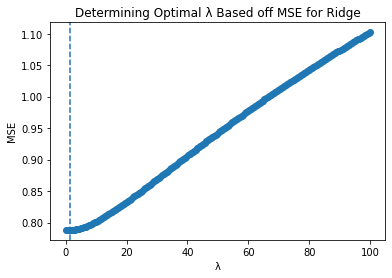

In [ ]:
def ridgereg(x,y,_lambda):
  """
  Returns coefficients of betas based of Ridge Regression using Equation 3.44. If _lambda = 0, then it is just regular Linear Regression
  Beta_hat = ((X^T*X)^-1)*X^T*Y

  """
  #This is removing the first col of 1s
  x = standardization(x,0) 
  x = x.to_numpy() #converts selected pandas df into numpy object
  Y = y.to_numpy() #converts selected pandas df into numpy object
  #X = np.append(np.ones((x.shape[0],1)), x, axis = 1) #appends the columns of 1s to the beginning 
  X = x
  #beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)+_lambda*np.identity(x.shape[1]+1)), X.T),Y) #follows equation 3.44
  beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)+_lambda*np.identity(x.shape[1])), X.T),Y) #follows equation 3.44, with columns of 1s not included
  return(beta)

"""
#This includes the first col of 1s
def ridgereg(x,y,_lambda):
  inputs are pandas dataframe, returns coefficients of betas based of Ridge Regression. If _lambda = 0, then it is just regular Linear Regression
  x = standardization(x,0) 
  x = x.to_numpy() #converts selected pandas df into numpy object
  Y = y.to_numpy() #converts selected pandas df into numpy object
  X = np.append(np.ones((x.shape[0],1)), x, axis = 1) #appends the columns of 1s to the beginning 
  beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)+_lambda*np.identity(x.shape[1]+1)), X.T),Y) #follows equation 3.44
  return(beta)
"""

print("Using a ridge regression on the training set, beta is: \n", ridgereg(x_train,y_train,0))

#Cross validation is on page 61

def MSE_ridgereg(x_test,y_test,x_train,y_train,_lambda):
  """
  inputs are pandas dataframe, returns the MSE
  x_test and y_test are what are being fitted compared to x_train and y_train, where coefficients of betas were found
  """
  beta = ridgereg(x_train,y_train,_lambda) #follows function above
  x_test = standardization(x_test,0) 
  x_test = x_test.to_numpy() #converts selected pandas df into numpy object
  y_test = y_test.to_numpy() #converts selected pandas df into numpy object
  Y_predicted = np.zeros(len(y_test)) #initialize
  for i in range(0,len(y_test)):
    Y_predicted[i] = np.dot(beta[0:], x_test[i][:])
    #Y_predicted[i] = beta[0] + np.dot(beta[1:], x_test[i][:]) ############## DO I NEED TO FIT RIDGE REG THROUGH ORIGIN???
  Y_actual_average = y_train.mean() ######################################## DO I NEED TO USE MEAN OF Y_ACTUAL AS NEW INTERCEPT???
  #mse = sum(np.square(Y_predicted-y_test))/len(y_test)
  mse = sum(np.square(Y_predicted+Y_actual_average-y_test))/len(y_test)
  return(mse)

ridge_lambda_array = np.linspace(0,100,200) 
ridge_MSE_array = np.zeros(len(ridge_lambda_array)) #initialize

#Right now, it's testing with the training and test, not validation and test as Keene wants it
"""
SO COME BACK TO THIS LATER
"""
for i in range(len(ridge_lambda_array)):
  ridge_MSE_array[i] = MSE_ridgereg(x_validation,y_validation,x_train,y_train,ridge_lambda_array[i])

#print(ridge_MSE_array)
#print(lambda_array[np.argmin(ridge_MSE_array)]) #returns value in lambda_array where the minimum in the MSE_array occured

print(f"The optimal lambda I found using the validation set is {ridge_lambda_array[np.argmin(ridge_MSE_array)]}")
print(f"At this optimal lambda, the MSE on the test set is {MSE_ridgereg(x_test,y_test,x_train,y_train,_lambda=ridge_lambda_array[np.argmin(ridge_MSE_array)])}")

plt.plot(ridge_lambda_array,ridge_MSE_array,linestyle='--', marker='o')
plt.axvline(x=ridge_lambda_array[np.argmin(ridge_MSE_array)],linestyle='--') #plots value in lambda_array where the minimum in the MSE_array occured
plt.title("Determining Optimal λ Based off MSE for Ridge")
plt.xlabel("λ")
plt.ylabel("MSE")
plt.show()

Replicated Figure 3.8

Text(0, 0.5, 'β')

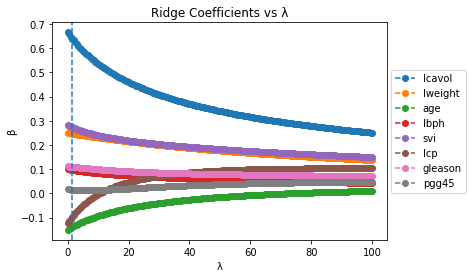

In [ ]:
ridge_lambda_array = np.linspace(0,100,200) 
ridge_beta = np.zeros((len(ridge_lambda_array),8))
columns_label = df.columns

for i in range(len(ridge_lambda_array)):
  #ridge_beta[i] = ridgereg(x_train,y_train,ridge_lambda_array[i])[1:] #this is including the columns of 1s
  ridge_beta[i] = ridgereg(x_train,y_train,ridge_lambda_array[i])[0:]

for i in range(ridge_beta.shape[1]):
  x = ridge_beta[:,i]
  plt.plot(ridge_lambda_array,x,label=columns_label[i],linestyle='--', marker='o')

plt.axvline(x=ridge_lambda_array[np.argmin(ridge_MSE_array)],linestyle='--')
plt.title("Ridge Coefficients vs λ")
plt.legend(loc="right",bbox_to_anchor=(1.25, 0.5))
plt.xlabel("λ")
plt.ylabel("β")

# Part C

The optimal lambda I found using the validation set is 0.01
At this optimal lambda, the MSE on the test set is 0.15035299365363292


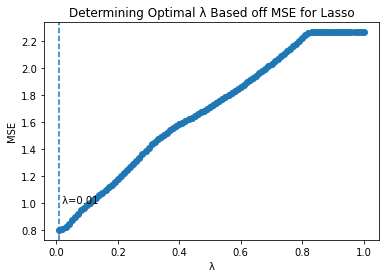

Text(0, 0.5, 'MSE')

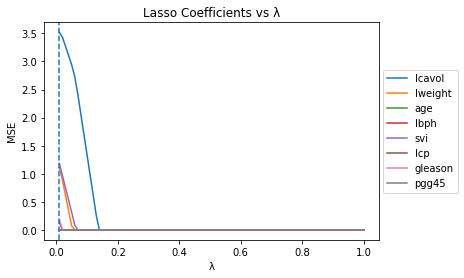

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


columns_label = df.columns
lasso_lambda_array = np.linspace(0.01,1,100) #excluding where lambda = 0 as there is a suggestion NOT to use it since using regular Linear Regression is better
lasso_MSE_array = np.zeros(len(lasso_lambda_array))


#This for loop fits the validation set to the training set
for i in range(len(lasso_lambda_array)):
  lasso = Lasso(alpha=lasso_lambda_array[i]) #fit_intercept = 0
  
  ss1 = StandardScaler()
  ss2 = StandardScaler()
  x_train = ss1.fit_transform(x_train)
  x_validation = ss2.fit_transform(x_validation)

  lasso.fit(x_train,y_train)
  y_predicted = lasso.predict(x_validation)
  lasso_MSE_array[i] = mean_squared_error(y_predicted,y_validation) 

#This is my optimal lambda from the for loop right above
optimal_lambda = lasso_lambda_array[np.argmin(lasso_MSE_array)]

print(f"The optimal lambda I found using the validation set is {optimal_lambda}")

#This function determines the MSE of the test set using the training set and the optimal lambda
def msebestlambdavalidation(x_test,y_test,x_train,y_train,_lambda):
  lasso = Lasso(alpha=_lambda)
  ss1 = StandardScaler()
  ss2 = StandardScaler()

  x_train = ss1.fit_transform(x_train)
  x_test = ss2.fit_transform(x_test)

  lasso.fit(x_train,y_train)
  y_predicted = lasso.predict(x_test)
  mse = mean_squared_error(y_predicted,y_test)
  return(mse)

print(f"At this optimal lambda, the MSE on the test set is {msebestlambdavalidation(x_test,y_test,x_train,y_train,optimal_lambda)}")


plt.plot(lasso_lambda_array,lasso_MSE_array,linestyle='--', marker='o')
plt.axvline(x=optimal_lambda,linestyle='--')
plt.title("Determining Optimal λ Based off MSE for Lasso")
optimal_lambda_rounded = round(optimal_lambda,2)
plt.text(optimal_lambda,1,f" λ={optimal_lambda_rounded}")

#plt.legend(loc="right",bbox_to_anchor=(1.25, 0.5))
plt.xlabel("λ")
plt.ylabel("MSE")
plt.show()



#Lasso vs Lambda
empty = np.zeros((len(lasso_lambda_array),8))

for i in range(len(lasso_lambda_array)):
  lasso = Lasso(alpha=lasso_lambda_array[i])
  scaler = StandardScaler()
  scaled_x = scaler.fit_transform(x_train)
  scaled_x = rescaling(x_train)

  lasso.fit(scaled_x,y_train)
  empty[i] = lasso.coef_


for i in range(empty.shape[1]):
  #x = empty[0:(len(lasso_lambda_array)-80),i]
  #plt.plot(lasso_lambda_array[0:(len(lasso_lambda_array)-80)],x,label=columns_label[i])
  x = empty[:,i]
  plt.plot(lasso_lambda_array,x,label=columns_label[i])

plt.axvline(x=optimal_lambda,linestyle='--')
plt.title("Lasso Coefficients vs λ")
plt.legend(loc="right",bbox_to_anchor=(1.25, 0.5))
plt.xlabel("λ")
plt.ylabel("MSE")

# Selecting My Own Dataset

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

#http://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength

"""
Cement (component 1) -- quantitative -- kg in a m3 mixture -- Input Variable
Blast Furnace Slag (component 2) -- quantitative -- kg in a m3 mixture -- Input Variable
Fly Ash (component 3) -- quantitative -- kg in a m3 mixture -- Input Variable
Water (component 4) -- quantitative -- kg in a m3 mixture -- Input Variable
Superplasticizer (component 5) -- quantitative -- kg in a m3 mixture -- Input Variable
Coarse Aggregate (component 6) -- quantitative -- kg in a m3 mixture -- Input Variable
Fine Aggregate (component 7) -- quantitative -- kg in a m3 mixture -- Input Variable
Age -- quantitative -- Day (1~365) -- Input Variable
Concrete compressive strength -- quantitative -- MPa -- Output Variable
"""

df = pd.read_excel("Concrete_Data.xls")

df_train, df_validation, df_test = np.split(df.sample(frac=1, random_state=10), [int(.8*len(df)), int(.9*len(df))]) #lengths of 824, 103, 103 respectively


#input = "Age (day)"
#plt.scatter(df[input],df[output], marker='o')
#plt.show()

output = "Concrete compressive strength" #this is just the output column. I renamed the actual columns since some had an extremely high character count

#Isolating Y (+2)
y_train = df_train[output] 
y_validation = df_validation[output]
y_test = df_test[output]

#Isolating X (+2)
x_train = df_train.drop([output], axis=1) 
x_validation = df_validation.drop([output], axis=1)
x_test = df_test.drop([output], axis=1)


def standardization(x,val):
  """
  Input is a pandas dataframe. For each column, standardizes it by x' = (x-mu)/sigma. val can be 1 (default arg of std()) which is sample, or 0 which is population. 
  Doing so results in mu = 0 and sigma = 1
  """
  x = (x - x.mean())/x.std(ddof=val)
  return(x)


def rescaling(x):
  x = (x - x.max())/(x.max() - x.min())
  return(x)

#Part A


In [ ]:
def linreg(x,y):
  """
  Returns coefficients of betas utilizing equation 3.6. Column of 1s is appended to X matrix
  Beta_hat = ((X^T*X)^-1)*X^T*Y
  """
  x = standardization(x,0) 
  x = x.to_numpy() #converts selected pandas df into numpy object
  Y = y.to_numpy() 
  X = np.append(np.ones((x.shape[0],1)), x, axis = 1) #appends the columns of 1s to the beginning 
  beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T),Y) #follows equation 3.6
  return(beta)

beta = linreg(x_train,y_train)

print("----------------------------------")
print("Using a linear regression, beta is: \n", beta)

def v_j(x):
  """
  Returns diagonal elements of (X^T*X)^-1
  """
  x = standardization(x,0)  
  x = x.to_numpy() 
  X = np.append(np.ones((x.shape[0],1)), x, axis = 1) #appends the columns of 1s to the beginning 
  return(np.diag(np.linalg.inv(np.dot(X.T, X))))

diag_v = v_j(x_train)


def prediction(x,y,x_train,y_train):
  """
  inputs are pandas dataframe, returns the predicted outcome
  x and y are what are being fitted compared to x_train and y_train, where coefficients of betas are found using x_train and y_train
  """
  beta = linreg(x_train,y_train) #follows function above
  x = standardization(x,0)  
  x = x.to_numpy() #converts selected pandas df into numpy object
  y = y.to_numpy() #converts selected pandas df into numpy object
  Y_predicted = np.zeros(len(y)) #initialize
  for i in range(0,len(y)):
    Y_predicted[i] = beta[0] + np.dot(beta[1:], x[i][:])
  return(Y_predicted)

y_predicted = prediction(x_train,y_train,x_train,y_train)

def sigma_hat(x,y_actual,y_predicted):
  """
  Returns sigma_hat utilizing equation 3.8.
  sigma_hat^2 = (1/(N-P-1))sum((y_actual-y_predicted)^2)
  """
  N = x.shape[0]
  p = x.shape[1]
  sigma = math.sqrt((1/(N-p-1))*sum(np.square(y_predicted-y_actual)))
  return(sigma)

sigma = sigma_hat(x_train,y_train,y_predicted)

def std_error(sigma_hat,v_j):
  """
  denominator of Equation 3.12
  standard error = sigma_hat*sqrt(v_j)
  """
  std_err = np.zeros(len(v_j))
  for i in range(len(v_j)):
    std_err[i] = sigma_hat*math.sqrt(v_j[i])
  return(std_err)

standard_error = std_error(sigma,diag_v)
print("------------------------------------")
print("The standard error of the training set is:", standard_error)

def zscore(beta,stderr):
  """
  Returns z-score utilizing equation 3.12
  z-score = beta/std_error
  """
  if len(beta) != len(stderr):
    raise("beta and standard error are not same lengths. you did something wrong")
  z = np.zeros(len(beta))
  for i in range(len(beta)):
    z[i] = beta[i]/stderr[i]
  return(z)

z_score = zscore(beta,standard_error)
print("------------------------------------")
print("The z score of the training set is:", z_score)
print("------------------------------------")


mse_baseline = np.mean(y_train)
print(f"The MSE baseline is {mse_baseline}")

----------------------------------
Using a linear regression, beta is: 
 [36.06190397 13.06039082  9.51089148  5.98048364 -2.93851737  1.78800161
  1.54107659  2.0247028   7.06046607]
------------------------------------
The standard error of the training set is: [0.36113715 0.97933657 0.97996366 0.90039684 0.95129025 0.60706165
 0.80696813 0.92989132 0.38483226]
------------------------------------
The z score of the training set is: [99.85653365 13.33595746  9.70535117  6.64205311 -3.08898084  2.94533778
  1.90971185  2.17735424 18.34686665]
------------------------------------
The MSE baseline is 36.061903970870596


In [ ]:
correlation = df_train.corr()
correlation.drop(["Concrete compressive strength"], axis=0, inplace=True) #removes unneeded rows
correlation.drop(["Concrete compressive strength"], axis=1, inplace=True) #removes unneeded columns
correlation.style

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
Cement,1.000000,-0.265262,-0.415598,-0.085207,0.090049,-0.139109,-0.182460,0.077356
Blast Furnace Slag,-0.265262,1.000000,-0.329909,0.102419,0.051917,-0.268591,-0.314281,-0.037387
Fly Ash,-0.415598,-0.329909,1.000000,-0.241506,0.358671,-0.014074,0.094476,-0.172703
Water,-0.085207,0.102419,-0.241506,1.000000,-0.648022,-0.193223,-0.466629,0.293418
Superplasticizer,0.090049,0.051917,0.358671,-0.648022,1.000000,-0.260532,0.227558,-0.199730
Coarse Aggregate,-0.139109,-0.268591,-0.014074,-0.193223,-0.260532,1.000000,-0.148943,-0.033404
Fine Aggregate,-0.182460,-0.314281,0.094476,-0.466629,0.227558,-0.148943,1.000000,-0.143570
Age,0.077356,-0.037387,-0.172703,0.293418,-0.199730,-0.033404,-0.143570,1.000000


In [ ]:
table_3_2_rows = ["Intercept","Cement", "Blast Furnace Slag", "Fly Ash", "Water", "Superplasticizer", "Coarse Aggregate", "Fine Aggregate", "Age"]

table_3_2 = {"Coefficient": beta,
            "Std. Error": standard_error,
            "Z Score": z_score
            }

df_table_3_2 = pd.DataFrame(table_3_2, index=table_3_2_rows)
df_table_3_2.style

,Coefficient,Std. Error,Z Score
Intercept,36.061904,0.361137,99.856534
Cement,13.060391,0.979337,13.335957
Blast Furnace Slag,9.510891,0.979964,9.705351
Fly Ash,5.980484,0.900397,6.642053
Water,-2.938517,0.951290,-3.088981
Superplasticizer,1.788002,0.607062,2.945338
Coarse Aggregate,1.541077,0.806968,1.909712
Fine Aggregate,2.024703,0.929891,2.177354
Age,7.060466,0.384832,18.346867


In [ ]:
def MSE_linreg(x_test,y_test,x_train,y_train):
  """
  inputs are pandas dataframe, returns the MSE
  x_test and y_test are what are being fitted compared to x_train and y_train, where coefficients of betas were found
  """
  beta = linreg(x_train,y_train) #follows function above
  x_test = standardization(x_test,0) 
  x_test = x_test.to_numpy() #converts selected pandas df into numpy object
  y_test = y_test.to_numpy() #converts selected pandas df into numpy object
  Y_predicted = np.zeros(len(y_test)) #initialize
  for i in range(0,len(y_test)):
    Y_predicted[i] = beta[0] + np.dot(beta[1:], x_test[i][:])
  mse = sum(np.square(Y_predicted-y_test))/len(y_test)
  return(mse)

print("---------")
print("The MSE of the test dataset is:", MSE_linreg(x_test,y_test,x_train,y_train))

---------
The MSE of the test dataset is: 119.07953432658736


# Part B


Using a ridge regression, beta is: 
 [13.06039082  9.51089148  5.98048364 -2.93851737  1.78800161  1.54107659
  2.0247028   7.06046607]
The optimal lambda I found using the validation set is 4.081632653061225
At this optimal lambda, the MSE on the test set is 118.23761686830757


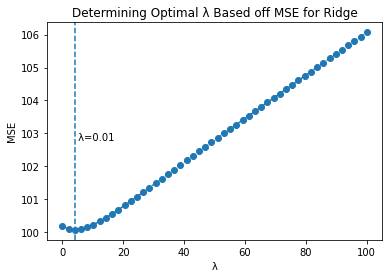

In [ ]:
def ridgereg(x,y,_lambda):
  """
  inputs are pandas dataframe, returns coefficients of betas based of Ridge Regression. If _lambda = 0, then it is just regular Linear Regression
  """
  #No need to add columns of 1s, as to not penalize the intercepts
  x = standardization(x,0) 
  x = x.to_numpy() #converts selected pandas df into numpy object
  Y = y.to_numpy() #converts selected pandas df into numpy object
  X = x
  beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)+_lambda*np.identity(x.shape[1])), X.T),Y) #follows equation 3.44
  return(beta)

"""
#This includes the first col of 1s
def ridgereg(x,y,_lambda):
  inputs are pandas dataframe, returns coefficients of betas based of Ridge Regression. If _lambda = 0, then it is just regular Linear Regression
  x = standardization(x,0) 
  x = x.to_numpy() #converts selected pandas df into numpy object
  Y = y.to_numpy() #converts selected pandas df into numpy object
  X = np.append(np.ones((x.shape[0],1)), x, axis = 1) #appends the columns of 1s to the beginning 
  beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)+_lambda*np.identity(x.shape[1]+1)), X.T),Y) #follows equation 3.44
  return(beta)
"""

print("Using a ridge regression, beta is: \n", ridgereg(x_train,y_train,0))

#Cross validation is on page 61

def MSE_ridgereg(x_test,y_test,x_train,y_train,_lambda):
  """
  inputs are pandas dataframe, returns the MSE
  x_test and y_test are what are being fitted compared to x_train and y_train, where coefficients of betas were found
  """
  beta = ridgereg(x_train,y_train,_lambda) #follows function above
  x_test = standardization(x_test,0) 
  x_test = x_test.to_numpy() #converts selected pandas df into numpy object
  y_test = y_test.to_numpy() #converts selected pandas df into numpy object
  Y_predicted = np.zeros(len(y_test)) #initialize
  for i in range(0,len(y_test)):
    Y_predicted[i] = np.dot(beta[0:], x_test[i][:])
    #Y_predicted[i] = beta[0] + np.dot(beta[1:], x_test[i][:]) ############## DO I NEED TO FIT RIDGE REG THROUGH ORIGIN???
  Y_actual_average = y_train.mean() ######################################## DO I NEED TO USE MEAN OF Y_ACTUAL AS NEW INTERCEPT???
  #mse = sum(np.square(Y_predicted-y_test))/len(y_test)
  mse = sum(np.square(Y_predicted+Y_actual_average-y_test))/len(y_test) 
  return(mse)

ridge_lambda_array = np.linspace(0,100,50) 
ridge_MSE_array = np.zeros(len(ridge_lambda_array)) #initialize

#Right now, it's testing with the training and test, not validation and test as Keene wants it
"""
SO COME BACK TO THIS LATER
"""
for i in range(len(ridge_lambda_array)):
  ridge_MSE_array[i] = MSE_ridgereg(x_validation,y_validation,x_train,y_train,ridge_lambda_array[i])

print(f"The optimal lambda I found using the validation set is {ridge_lambda_array[np.argmin(ridge_MSE_array)]}")
print(f"At this optimal lambda, the MSE on the test set is {MSE_ridgereg(x_test,y_test,x_train,y_train,_lambda=ridge_lambda_array[np.argmin(ridge_MSE_array)])}")


plt.plot(ridge_lambda_array,ridge_MSE_array,linestyle='--', marker='o')
plt.axvline(x=ridge_lambda_array[np.argmin(ridge_MSE_array)],linestyle='--') #plots value in lambda_array where the minimum in the MSE_array occured
plt.text(ridge_lambda_array[np.argmin(ridge_MSE_array)],np.median(ridge_MSE_array),f" λ={optimal_lambda_rounded}")

plt.title("Determining Optimal λ Based off MSE for Ridge")
plt.xlabel("λ")
plt.ylabel("MSE")
plt.show()

Text(0, 0.5, 'β')

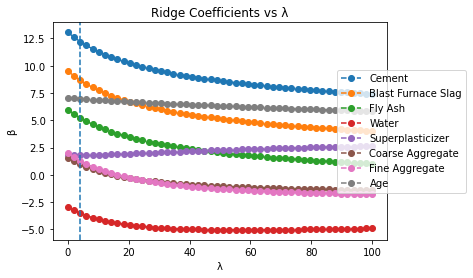

In [ ]:
ridge_lambda_array = np.linspace(0,100,50) 
ridge_beta = np.zeros((len(ridge_lambda_array),8))
columns_label = df.columns

for i in range(len(ridge_lambda_array)):
  #ridge_beta[i] = ridgereg(x_train,y_train,ridge_lambda_array[i])[1:] #this is including the columns of 1s
  ridge_beta[i] = ridgereg(x_train,y_train,ridge_lambda_array[i])[0:]

for i in range(ridge_beta.shape[1]):
  x = ridge_beta[:,i]
  plt.plot(ridge_lambda_array,x,label=columns_label[i],linestyle='--', marker='o')

plt.axvline(x=ridge_lambda_array[np.argmin(ridge_MSE_array)],linestyle='--')
plt.title("Ridge Coefficients vs λ")
plt.legend(loc="right",bbox_to_anchor=(1.25, 0.5))
plt.xlabel("λ")
plt.ylabel("β")

#Part C


The optimal lambda I found using the validation set is 0.14
At this optimal lambda, the MSE on the test set is 116.99636919063269


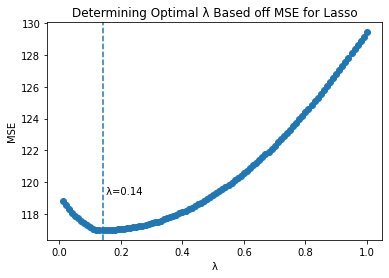

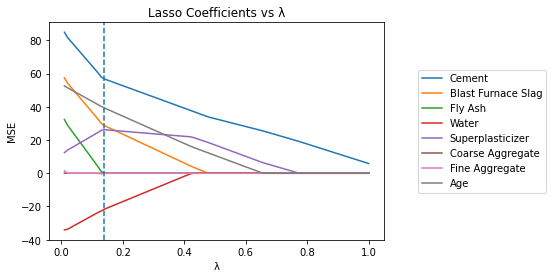

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


columns_label = df.columns
lasso_lambda_array = np.linspace(0.01,1,100) #excluding where lambda = 0 as there is a suggestion NOT to use it since using regular Linear Regression is better
lasso_MSE_array = np.zeros(len(lasso_lambda_array))


for i in range(len(lasso_lambda_array)):
  lasso = Lasso(alpha=lasso_lambda_array[i]) #fit_intercept = 0
  
  ss1 = StandardScaler()
  ss2 = StandardScaler()
  x_train = ss1.fit_transform(x_train)
  x_test = ss2.fit_transform(x_test)

  lasso.fit(x_train,y_train)
  y_predicted = lasso.predict(x_test)
  lasso_MSE_array[i] = mean_squared_error(y_predicted,y_test) 


optimal_lambda = lasso_lambda_array[np.argmin(lasso_MSE_array)]
print(f"The optimal lambda I found using the validation set is {optimal_lambda}")

#This function determines the MSE of the test set using the training set and the optimal lambda
def msebestlambdavalidation(x_test,y_test,x_train,y_train,_lambda):
  lasso = Lasso(alpha=_lambda)
  ss1 = StandardScaler()
  ss2 = StandardScaler()

  x_train = ss1.fit_transform(x_train)
  x_test = ss2.fit_transform(x_test)

  lasso.fit(x_train,y_train)
  y_predicted = lasso.predict(x_test)
  mse = mean_squared_error(y_predicted,y_test)
  return(mse)

print(f"At this optimal lambda, the MSE on the test set is {msebestlambdavalidation(x_test,y_test,x_train,y_train,optimal_lambda)}")


plt.plot(lasso_lambda_array,lasso_MSE_array,linestyle='--', marker='o')
plt.axvline(x=optimal_lambda,linestyle='--')
plt.title("Determining Optimal λ Based off MSE for Lasso")
optimal_lambda_rounded = round(optimal_lambda,2)
plt.text(optimal_lambda,np.median(lasso_MSE_array),f" λ={optimal_lambda_rounded}")

#plt.legend(loc="right",bbox_to_anchor=(1.25, 0.5))
plt.xlabel("λ")
plt.ylabel("MSE")
plt.show()

#Lasso vs Lambda
empty = np.zeros((len(lasso_lambda_array),8))

for i in range(len(lasso_lambda_array)):
  lasso = Lasso(alpha=lasso_lambda_array[i])
  scaler = StandardScaler()
  scaled_x = scaler.fit_transform(x_train)
  scaled_x = rescaling(x_train)

  lasso.fit(scaled_x,y_train)
  empty[i] = lasso.coef_


for i in range(empty.shape[1]):
  #x = empty[0:(len(lasso_lambda_array)-80),i]
  #plt.plot(lasso_lambda_array[0:(len(lasso_lambda_array)-80)],x,label=columns_label[i])
  x = empty[:,i]
  plt.plot(lasso_lambda_array,x,label=columns_label[i])

plt.axvline(x=optimal_lambda,linestyle='--')
plt.title("Lasso Coefficients vs λ")
plt.legend(loc="right",bbox_to_anchor=(1.5, 0.5))
plt.xlabel("λ")
plt.ylabel("MSE")
plt.show()


#Introducing Non-Linear Columns from Pre-Exisiting Data

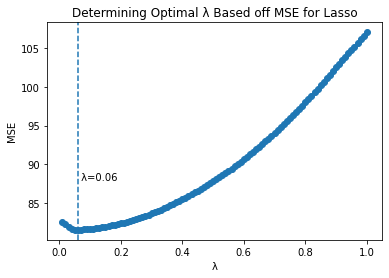

By adding a nonlinear feature (age squared), the MSE is now 81.53375060003904


Text(0, 0.5, 'MSE')

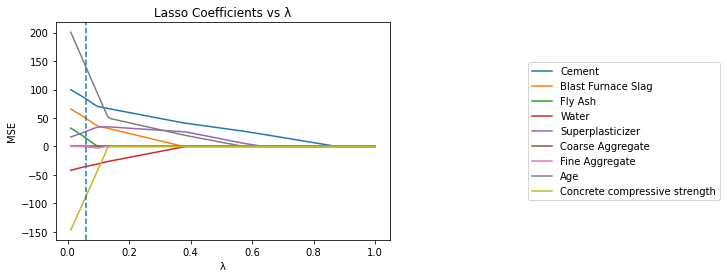

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


#df = pd.read_excel("http://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls")
df = pd.read_excel("Concrete_Data.xls")

#New additional features
#df["9"] = df.iloc[:,0]*df.iloc[:,0]
#df["10"] = df.iloc[:,1]*df.iloc[:,1]
#df["11"] = df.iloc[:,2]*df.iloc[:,2]
#df["12"] = df.iloc[:,3]*df.iloc[:,3]
#df["13"] = df.iloc[:,4]*df.iloc[:,4]
#df["14"] = df.iloc[:,5]*df.iloc[:,5]
#df["15"] = df.iloc[:,6]*df.iloc[:,6]
df["16"] = df.iloc[:,7]*df.iloc[:,7]

#df["17"] = np.sqrt(df.iloc[:,0])
#df["18"] = np.sqrt(df.iloc[:,1])
#df["19"] = np.sqrt(df.iloc[:,2])
#df["20"] = np.sqrt(df.iloc[:,3])
#df["21"] = np.sqrt(df.iloc[:,4])
#df["22"] = np.sqrt(df.iloc[:,5])
#df["23"] = np.sqrt(df.iloc[:,6])
#df["24"] = np.sqrt(df.iloc[:,7])



df_train, df_validation, df_test = np.split(df.sample(frac=1, random_state=100), [int(.8*len(df)), int(.9*len(df))]) #lengths of 824, 103, 103 respectively
output = "Concrete compressive strength"
#output = "Concrete compressive strength(MPa, megapascals) " #this is just the output column. I renamed the actual columns since some had an extremely high character count


#Isolating Y (+2)
y_train = df_train[output] 
#y_validation = df_validation[output]
y_test = df_test[output]

#Isolating X (+2)
x_train = df_train.drop([output], axis=1) 
#x_validation = df_validation.drop([output], axis=1)
x_test = df_test.drop([output], axis=1)

x_column_length = len(x_train.columns)


columns_label = df.columns
lasso_lambda_array = np.linspace(0.01,1,100) #excluding where lambda = 0 as there is a suggestion NOT to use it since using regular Linear Regression is better
lasso_MSE_array = np.zeros(len(lasso_lambda_array))


for i in range(len(lasso_lambda_array)):
  lasso = Lasso(alpha=lasso_lambda_array[i]) #fit_intercept = 0
  
  ss1 = StandardScaler()
  ss2 = StandardScaler()
  x_train = ss1.fit_transform(x_train)
  x_test = ss2.fit_transform(x_test)

  lasso.fit(x_train,y_train)
  y_predicted = lasso.predict(x_test)
  lasso_MSE_array[i] = mean_squared_error(y_predicted,y_test) 


optimal_lambda = lasso_lambda_array[np.argmin(lasso_MSE_array)]
plt.plot(lasso_lambda_array,lasso_MSE_array,linestyle='--', marker='o')
plt.axvline(x=optimal_lambda,linestyle='--')
plt.title("Determining Optimal λ Based off MSE for Lasso")
optimal_lambda_rounded = round(optimal_lambda,2)
plt.text(optimal_lambda,np.median(lasso_MSE_array),f" λ={optimal_lambda_rounded}")

#plt.legend(loc="right",bbox_to_anchor=(1.25, 0.5))
plt.xlabel("λ")
plt.ylabel("MSE")
plt.show()

print(f"By adding a nonlinear feature (age squared), the MSE is now {np.min(lasso_MSE_array)}") 

#Lasso vs Lambda
empty = np.zeros((len(lasso_lambda_array),x_column_length))

for i in range(len(lasso_lambda_array)):
  lasso = Lasso(alpha=lasso_lambda_array[i])
  scaler = StandardScaler()
  scaled_x = scaler.fit_transform(x_train)
  scaled_x = rescaling(x_train)
  lasso.fit(scaled_x,y_train)
  empty[i] = lasso.coef_


for i in range(empty.shape[1]):
  x = empty[:,i]
  plt.plot(lasso_lambda_array,x,label=columns_label[i])

plt.axvline(x=optimal_lambda,linestyle='--')
plt.title("Lasso Coefficients vs λ")
plt.legend(loc="right",bbox_to_anchor=(2, 0.5))
plt.xlabel("λ")
plt.ylabel("MSE")


# RANDOM STUFF DON'T USE THIS IN FINAL



In [ ]:
def standardization(x,val):
  """
  Input is a pandas dataframe. For each column, standardizes it by x' = (x-mu)/sigma. val can be 1 (default arg of std()) which is sample, or 0 which is population
  """
  x = (x - x.mean())/x.std(ddof=val)
  return x


def linreg(x,y):
  """
  inputs are pandas dataframe, returns coefficients of betas
  """
  x = standardization(x,0) 
  x = x.to_numpy() #converts selected pandas df into numpy object
  Y = y.to_numpy() #converts selected pandas df into numpy object
  X = np.append(np.ones((x.shape[0],1)), x, axis = 1) #appends the columns of 1s to the beginning 
  beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T),Y) #follows equation 3.6
  return(beta)

print("----------------------------------")
print("Using a linear regression, beta is: \n", linreg(x_train,y_train))

def v_j(x):
  """
  Returns diagonal elements of (XX^T)^-1 
  """
  x = (x - x.mean())/x.std(ddof=0) #ddof of 0 results in using population std, NOT sample std
  x = x.to_numpy() #converts selected pandas df into numpy object
  X = np.append(np.ones((x.shape[0],1)), x, axis = 1) #appends the columns of 1s to the beginning 
  return(np.diag(np.linalg.inv(np.dot(X.T, X))))

#print(v_j(x_train))
#print(np.sqrt(v_j(x_train)))


#Equation 3.8
N = df_train.shape[0]
p = df_train.shape[1]



def prediction(x,y):
  """
  inputs are pandas dataframe, returns the MSE
  x and y are what are being fitted compared to x_train and y_train, where coefficients of betas are found
  """
  beta = linreg(x_train,y_train) #follows function above
  x = x.to_numpy() #converts selected pandas df into numpy object
  y = y.to_numpy() #converts selected pandas df into numpy object
  Y_predicted = np.zeros(len(y)) #initialize
  for i in range(0,len(y)):
    Y_predicted[i] = beta[0] + np.dot(beta[1:], x[i][:])
  return(Y_predicted)

print(prediction(x_train,y_train))


def sigma_hat(x,y):
  beta = linreg(x,y)
  sigma = math.sqrt((1/(x.shape[0]-x.shape[1]-1))*sum(np.square(prediction(x,y)-y)))
  return(sigma)

print(sigma_hat(x_train,y_train))

print(x_train.shape[0])

sigma = math.sqrt((1/(N-p-1))*sum(np.square(prediction(x_train,y_train)-y_train)))
print(sigma)

def zscore(x,y):
  beta = linreg()


----------------------------------


AttributeError: ignored

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


"""
lasso = Lasso(alpha=0.1)
lasso.fit(x_train,y_train)

print("y-intercept is:", lasso.intercept_)
print(lasso.coef_)

predict_train = lasso.predict(x_train)
#print("MSE for the training set is:", mean_squared_error(predict_train,y_train))

predict_test = lasso.predict(x_test)
#print("MSE for the test set is:", mean_squared_error(predict_test,y_test))
"""

columns_label = df.columns

#lambda_array = np.linspace(0.01,0.5,20) #excluding where lambda = 0 as there is a suggestion NOT to use it since using regular Linear Regression is better
lambda_array = np.linspace(0.01,0.5,20) #excluding where lambda = 0 as there is a suggestion NOT to use it since using regular Linear Regression is better

empty = np.zeros((len(lambda_array),8))


"""
for i in range(len(lambda_array)):
  for j in lambda_array:
    lasso = Lasso(alpha=j)
    lasso.fit(x_train,y_train)
    beta = lasso.coef_
    empty[i] = beta
    #print(empty)  
"""

"""
for j in lambda_array:
  lasso = Lasso(alpha=j)
  lasso.fit(x_train,y_train)
  beta = lasso.coef_
  #print(beta)
  empty[np.where(lambda_array==j)] = beta
  #print(empty)  
"""



"""
for i in range(len(lambda_array)):
  lasso = Lasso(alpha=lambda_array[i])
  scaler = StandardScaler()
  scaled_x = scaler.fit_transform(x_train)
  lasso.fit(scaled_x,y_train)
  empty[i] = lasso.coef_
"""

empty = np.zeros((len(lambda_array),1))
for i in range(len(lambda_array)):
  lasso = Lasso(alpha=lambda_array[i])
  scaler = StandardScaler()
  scaled_x = scaler.fit_transform(x_train)
  lasso.fit(scaled_x,y_train)
  a = lasso.predict(scaled_x)
  empty[i] = mean_squared_error(a,y_train)



plt.plot(lambda_array,empty,linestyle='--', marker='o')
plt.title("Lasso Coefficients vs λ")
plt.legend(loc="right",bbox_to_anchor=(1.25, 0.5))
plt.xlabel("λ")
plt.ylabel("MSE")




"""
for i in range(empty.shape[1]):
  x = empty[:,i]
  plt.plot(lambda_array,x,label=columns_label[i],linestyle='--', marker='o')
"""

"""
This is for beta vs lambda (NOT MSE)

plt.title("Lasso Coefficients vs λ (NOT MSE)")
plt.legend(loc="right",bbox_to_anchor=(1.25, 0.5))
plt.xlabel("λ")
plt.ylabel("β")

plt.show()
"""






